# Projet : Everflow API Analytics

## Introduction

### Rôle
Ce projet a été conçu et réalisé par **Mohamed Lamine OULD BOUYA** dans le cadre d'un projet personnel pour mon **portfolio GitHub** 

Mon rôle : **développeur data / intégrateur API** - de la conception du client Python Everflow à la visualisation graphique des performances

### Objectif principal
Créer un outil **simple, automatisé et réutilisable** permettant de :
1. **Se connecter à l’API Everflow** à l’aide d’une clé d’API sécurisée.
2. **Extraire des statistiques agrégées** (revenus, payouts, conversions, clics) sur une **plage de dates donnée**.
3. **Calculer les profits** directement côté client (`profit = revenue − payout`).
4. **Visualiser les performances** avec des **graphiques automatiques** :
   - Profit par **offre (offer)**
   - Profit par **affilié (affiliate)**
   - Profit par **annonceur (advertiser)**
5. **Exporter les résultats** sous forme de graphiques PNG et d’un **rapport Markdown**.

### Points clés du projet
- Authentification via en-tête `X-Eflow-API-Key` (stocké dans `.env`)
- Endpoint principal : `POST /v1/networks/reporting/entity/table`
- Agrégation dynamique avec colonnes personnalisables (`offer`, `affiliate`, etc.)
- Traitement et calculs via **pandas**
- Visualisations claires générées avec **matplotlib**
- Mode **mock** inclus pour tester sans clé API


## Limites connues et pistes d’amélioration

### Limites techniques actuelles
1. **Plage temporelle limitée**  
   L’endpoint `entity/table` d’Everflow n’autorise qu’une **fenêtre maximale d’un an** par requête  
   -> Solution : découper automatiquement les requêtes par période (mois / trimestre) et agréger côté client

2. **Résultats partiels au-delà de 10 000 lignes**  
   L’API retourne au maximum **10 000 lignes** par appel (`incomplete_results = true`) 
   -> Solution : implémenter une pagination ou filtrer par offre/affilié pour réduire le volume

3. **Pas de filtrage avancé pour l’instant**  
   Le script ne gère pas encore les **filtres dynamiques** (pays, device, source, etc.)
   -> Amélioration possible : ajouter des paramètres “filters” et “exclusions” dans la fonction API

4. **Visualisation statique**  
   Les graphiques sont générés sous forme d’images statiques PNG 
   -> Évolution : créer un **dashboard interactif** avec **Plotly Dash** ou **Streamlit**

5. **Pas de monitoring en continu**  
   Le notebook exécute des rapports ponctuels 
   -> Amélioration : automatiser via un **cron job** ou une **intégration CI/CD** (GitHub Actions) pour générer des rapports journaliers

### Pistes d’amélioration à venir
- Intégration d’un **frontend web** pour visualiser les performances en temps réel 
- Support de nouveaux endpoints Everflow (clics, conversions, geo breakdowns) 
- Exportation automatique vers **Google Sheets**, **Power BI** ou **Tableau**  
- Ajout d’une API interne Flask/FastAPI pour exposer les agrégats calculés
- Utilisation d’un **cache local** (SQLite ou Redis) pour accélérer les traitements

> Ces améliorations rendraient le projet plus complet, proche d’un **mini-dashboard analytique professionnel**, tout en restant open-source et pédagogique.

## 1-) Dépendances
Installe/charge les libs nécessaires. --quiet évite le bruit dans la sortie.

In [1]:
# 1) Dépendances
%pip install --quiet python-dotenv requests pandas matplotlib

import os, json, textwrap
from pathlib import Path
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Option d'affichage
pd.set_option("display.max_columns", 50)

Note: you may need to restart the kernel to use updated packages.


## 2-) Configuration et paramètres
Charge automatiquement .env si présent. On peut soit remplir ta clé dans .env, soit la coller directement dans EFLOW_API_KEY ci-dessous

In [ ]:
# 2) Configuration et paramètres

# Charge automatiquement .env s'il existe à la racine du repo
load_dotenv(override=False)

# <- OPTION A : .env (recommandé, ne jamais commiter la clé)
EFLOW_API_KEY = os.getenv("EFLOW_API_KEY", "")           # si vide, on utilisera le mode mock
EFLOW_BASE_URL = os.getenv("EFLOW_BASE_URL", "https://api.eflow.team").rstrip("/")
EFLOW_TIMEZONE_ID = int(os.getenv("EFLOW_TIMEZONE_ID", "67"))  # 67 ~ Europe/Paris (exemple)
EFLOW_CURRENCY_ID = os.getenv("EFLOW_CURRENCY_ID", "USD")

# <- OPTION B : définir ici (décommenter et remplir)
# EFLOW_API_KEY = "PASTE_YOUR_KEY_HERE"

# Paramètres de la démo (modifiable à la volée)
FROM_DATE = "2025-03-15"
TO_DATE   = "2025-03-31"
OUT_DIR   = "out"  # les images & le rapport seront exportés ici

# Mode mock : True => n'appelle pas l'API, utilise des données factices intégrées
USE_MOCK = (EFLOW_API_KEY == "")

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

print("Base URL :", EFLOW_BASE_URL)
print("Timezone :", EFLOW_TIMEZONE_ID, "| Currency:", EFLOW_CURRENCY_ID)
print("Mock mode:", USE_MOCK)

Base URL : https://api.eflow.team
Timezone : 67 | Currency: USD
Mock mode: True


## 3-) Données factices
Pour les tests hors-API, on garde un petit échantillon réaliste conforme à la structure du “table” endpoint (colonnes + métriques)

In [3]:
# 3) Données factices (mock) — structure proche de /reporting/entity/table
MOCK_ROWS = [
    {
        "columns": {"offer": {"id": 101, "name": "Offer A"}, "affiliate": {"id": 11, "name": "Aff One"}, "advertiser": {"id": 5, "name": "Adv One"}},
        "metrics": {"revenue": 1234.5, "payout": 800.0, "cv": 100, "total_click": 2000}
    },
    {
        "columns": {"offer": {"id": 102, "name": "Offer B"}, "affiliate": {"id": 12, "name": "Aff Two"}, "advertiser": {"id": 6, "name": "Adv Two"}},
        "metrics": {"revenue": 900.0, "payout": 400.0, "cv": 80, "total_click": 1500}
    },
    {
        "columns": {"offer": {"id": 103, "name": "Offer C"}, "affiliate": {"id": 11, "name": "Aff One"}, "advertiser": {"id": 7, "name": "Adv Three"}},
        "metrics": {"revenue": 600.0, "payout": 450.0, "cv": 40, "total_click": 800}
    }
]
len(MOCK_ROWS)

3

## 4-) Client Everflow minimal
Fonction fetch_aggregated_table qui appelle POST /v1/networks/reporting/entity/table.
Paramètres clés :
- from, to, timezone_id, currency_id
- columns (ex. ["offer", "affiliate"])
La fonction retourne la liste des lignes"

In [4]:
# 4) Client Everflow minimal

HEADERS = {"X-Eflow-API-Key": EFLOW_API_KEY, "Content-Type": "application/json"}

def fetch_aggregated_table(from_date: str,
                           to_date: str,
                           columns: list[str],
                           timezone_id: int,
                           currency_id: str) -> list[dict]:
    """
    Appel l'endpoint d'agrégats 'table' et renvoie la liste de lignes (rows).
    Lève une exception si l'API retourne un code != 200.
    """
    url = f"{EFLOW_BASE_URL}/v1/networks/reporting/entity/table"
    payload = {
        "from": from_date,
        "to": to_date,
        "timezone_id": timezone_id,
        "currency_id": currency_id,
        "columns": [{"column": c} for c in columns],
        "query": {}
    }
    resp = requests.post(url, headers=HEADERS, json=payload, timeout=60)
    if resp.status_code != 200:
        raise RuntimeError(f"HTTP {resp.status_code}: {resp.text}")
    data = resp.json()

    # Selon les versions, la clé peut s'appeler "rows" (classique) ; on prévoit des fallbacks.
    rows = data.get("rows") or data.get("data") or data.get("result") or []
    if data.get("incomplete_results"):
        print("⚠️ Résultats incomplets: réduis la plage de dates ou les colonnes.")
    return rows

## 5-) Extraction des données
Si USE_MOCK=True, on saute l’appel réseau. Sinon on interroge l’API

In [5]:
# 5) Extraction des données

COLUMNS = ["offer", "affiliate"]  # inclut l'advertiser dans la réponse quand "offer" est demandé (selon la config)

if USE_MOCK:
    rows = MOCK_ROWS
else:
    rows = fetch_aggregated_table(
        from_date=FROM_DATE,
        to_date=TO_DATE,
        columns=COLUMNS,
        timezone_id=EFLOW_TIMEZONE_ID,
        currency_id=EFLOW_CURRENCY_ID
    )

print(f"Lignes récupérées : {len(rows)}")
rows[:1]  # aperçu JSON brut d'une ligne

Lignes récupérées : 3


[{'columns': {'offer': {'id': 101, 'name': 'Offer A'},
   'affiliate': {'id': 11, 'name': 'Aff One'},
   'advertiser': {'id': 5, 'name': 'Adv One'}},
  'metrics': {'revenue': 1234.5,
   'payout': 800.0,
   'cv': 100,
   'total_click': 2000}}]

## 6-) Transformation -> DataFrame
On aplatit les champs utiles : identifiants / noms et métriques
On calcule profit = revenue − payout

In [6]:
# 6) Transformation → DataFrame

def rows_to_df(rows: list[dict]) -> pd.DataFrame:
    records = []
    for r in rows:
        cols = r.get("columns", {})
        met  = r.get("metrics", {})
        offer      = cols.get("offer", {})
        affiliate  = cols.get("affiliate", {})
        advertiser = cols.get("advertiser", {})

        revenue = float(met.get("revenue", 0) or 0.0)
        payout  = float(met.get("payout", 0) or 0.0)
        profit  = revenue - payout

        records.append({
            "offer_id": offer.get("id"),
            "offer_name": offer.get("name"),
            "affiliate_id": affiliate.get("id"),
            "affiliate_name": affiliate.get("name"),
            "advertiser_id": advertiser.get("id"),
            "advertiser_name": advertiser.get("name"),
            "revenue": revenue,
            "payout": payout,
            "profit": profit,
            "cv": met.get("cv", 0),
            "total_click": met.get("total_click", 0),
        })
    return pd.DataFrame.from_records(records)

df = rows_to_df(rows)
df.head()

,offer_id,offer_name,affiliate_id,affiliate_name,advertiser_id,advertiser_name,revenue,payout,profit,cv,total_click
0,101,Offer A,11,Aff One,5,Adv One,1234.5,800.0,434.5,100,2000
1,102,Offer B,12,Aff Two,6,Adv Two,900.0,400.0,500.0,80,1500
2,103,Offer C,11,Aff One,7,Adv Three,600.0,450.0,150.0,40,800


## 7-) Agrégations utiles
Fonctions pour calculer le Top N par profit selon l’axe choisi

In [7]:
# 7) Agrégations utiles

def topn_profit_by(df: pd.DataFrame, by: str, n: int = 15) -> pd.DataFrame:
    """
    by ∈ {"offer", "affiliate", "advertiser"}
    Retourne le top N des profits agrégés par l'entité choisie.
    """
    assert by in {"offer", "affiliate", "advertiser"}
    name_col = f"{by}_name"
    id_col   = f"{by}_id"
    group = (
        df.groupby([id_col, name_col], dropna=False)["profit"]
          .sum()
          .reset_index()
          .sort_values("profit", ascending=False)
          .head(n)
    )
    return group

top_offers = topn_profit_by(df, "offer", n=15)
top_affiliates = topn_profit_by(df, "affiliate", n=15)
top_advertisers = topn_profit_by(df, "advertiser", n=15)

top_offers

,offer_id,offer_name,profit
1,102,Offer B,500.0
0,101,Offer A,434.5
2,103,Offer C,150.0


## 8-) Visualisation
Utilisation de matplotlib (pas de seaborn). Chaque cellule génère un bar chart horizontal, l’enregistre en PNG et l’affiche

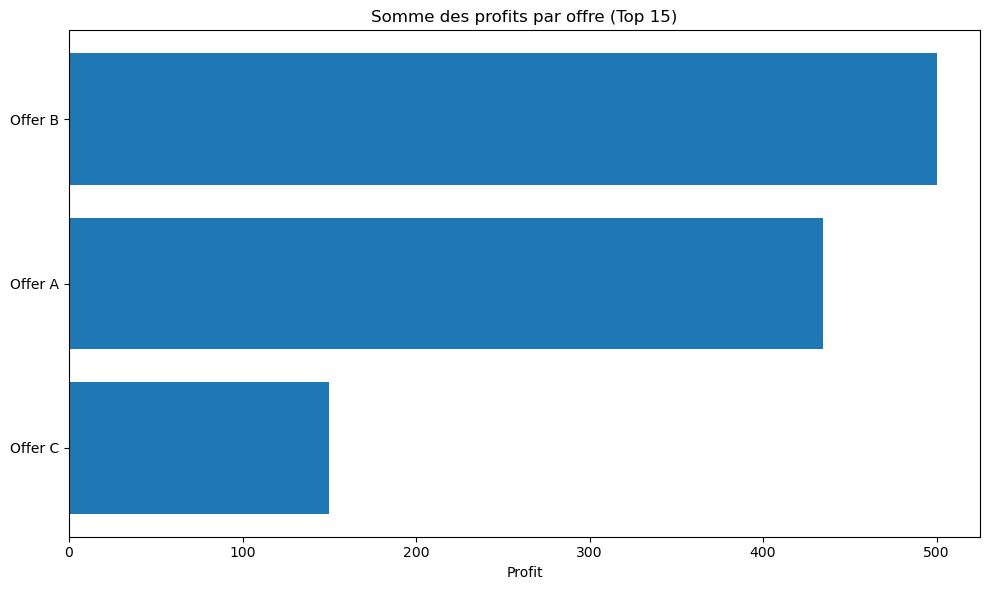

WindowsPath('out/profit_by_offer.png')

In [8]:
# 8a) Graphique — Profits par Offre
plt.figure(figsize=(10, 6))
tmp = top_offers.sort_values("profit", ascending=True)
plt.barh(tmp["offer_name"].astype(str), tmp["profit"])
plt.title("Somme des profits par offre (Top 15)")
plt.xlabel("Profit")
plt.tight_layout()
png_path_offers = Path(OUT_DIR) / "profit_by_offer.png"
plt.savefig(png_path_offers)
plt.show()
png_path_offers

## 9-) Rapport Markdown
Génère un README de résultats minimal dans le dossier out/ avec liens vers les PNG

In [9]:
# 9) Rapport Markdown

report_md = f"""# Rapport Everflow — {FROM_DATE} → {TO_DATE}

**Fuseau**: {EFLOW_TIMEZONE_ID} • **Devise**: {EFLOW_CURRENCY_ID}

## Profits par Offre
![profit_by_offer](profit_by_offer.png)

## Profits par Affilié
![profit_by_affiliate](profit_by_affiliate.png)

## Profits par Advertiser
![profit_by_advertiser](profit_by_advertiser.png)

_Généré par le notebook “Everflow API Analytics — Portfolio”_
"""

Path(OUT_DIR, "REPORT.md").write_text(report_md, encoding="utf-8")
Path(OUT_DIR, "REPORT.md")

WindowsPath('out/REPORT.md')

## 10-) Exécution “one-click”
Fonction utilitaire pour rejouer l’ensemble en une ligne avec d’autres dates

In [10]:
# 10) Exécution "one-click"

def run_pipeline(from_date: str, to_date: str, out_dir: str = "out", use_mock: bool = False):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    if use_mock:
        _rows = MOCK_ROWS
    else:
        _rows = fetch_aggregated_table(
            from_date=from_date,
            to_date=to_date,
            columns=["offer", "affiliate"],
            timezone_id=EFLOW_TIMEZONE_ID,
            currency_id=EFLOW_CURRENCY_ID
        )
    _df = rows_to_df(_rows)
    # Agrégations
    _offers = topn_profit_by(_df, "offer")
    _aff    = topn_profit_by(_df, "affiliate")
    _adv    = topn_profit_by(_df, "advertiser")

    # Graphiques (sauvegarde)
    def save_barh(df, value_col, label_col, title, path):
        plt.figure(figsize=(10,6))
        d = df.sort_values(value_col, ascending=True)
        plt.barh(d[label_col].astype(str), d[value_col])
        plt.title(title)
        plt.xlabel(value_col.capitalize())
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

    save_barh(_offers, "profit", "offer_name", "Somme des profits par offre (Top 15)", Path(out_dir)/"profit_by_offer.png")
    save_barh(_aff,    "profit", "affiliate_name", "Somme des profits par affilié (Top 15)", Path(out_dir)/"profit_by_affiliate.png")
    save_barh(_adv,    "profit", "advertiser_name", "Somme des profits par advertiser (Top 15)", Path(out_dir)/"profit_by_advertiser.png")

    # Rapport
    rep = f"""# Rapport Everflow — {from_date} → {to_date}

**Fuseau**: {EFLOW_TIMEZONE_ID} • **Devise**: {EFLOW_CURRENCY_ID}

## Profits par Offre
![profit_by_offer](profit_by_offer.png)

## Profits par Affilié
![profit_by_affiliate](profit_by_affiliate.png)

## Profits par Advertiser
![profit_by_advertiser](profit_by_advertiser.png)
"""
    Path(out_dir, "REPORT.md").write_text(rep, encoding="utf-8")
    return {"rows": len(_rows), "out": str(Path(out_dir).resolve())}

# Exemple:
run_pipeline(FROM_DATE, TO_DATE, OUT_DIR, use_mock=USE_MOCK)

{'rows': 3, 'out': 'C:\\Users\\ouldb\\Documents\\Everflow-API-Analytics\\out'}

# Conclusion et Résultats

### Résumé de l’exécution
Le notebook **Everflow API Analytics** a permis de :
- récupérer des statistiques agrégées de l’API Everflow sur une période donnée
- calculer les indicateurs de performance principaux : **revenu, payout, profit, conversions, clics**
- générer automatiquement **trois graphiques clés** :
  1. Profit par **offre (Offer)**
  2. Profit par **affilié (Affiliate)**
  3. Profit par **advertiser (Annonceur)**

Ces visuels permettent d’identifier rapidement les acteurs les plus performants du réseau.

### Visualisations générées
Les graphiques et le rapport final ont été enregistrés dans le dossier `out/` :
- `profit_by_offer.png`
- `profit_by_affiliate.png`
- `profit_by_advertiser.png`
- `REPORT.md`

Ci-dessous, un aperçu des résultats :

![profit_by_offer](out/profit_by_offer.png)
![profit_by_affiliate](out/profit_by_affiliate.png)
![profit_by_advertiser](out/profit_by_advertiser.png)

### Ce que démontre ce projet
- Maîtrise de l’intégration d’une **API REST analytique** (Everflow)  
- Transformation de données brutes JSON en **indicateurs exploitables** avec Pandas  
- Production de **visualisations automatiques** et d’un rapport réutilisable  
- Capacité à **structurer un projet complet** (authentification, logique métier, visualisation, rapport)

> *Ce projet illustre ma capacité à concevoir des pipelines de données simples mais robustes, capables de transformer des données API en insights visuels clairs et prêts à être partagés.*